# Homework 5 - Explore Wikipedia's hyperlinks network
In this assignment we analyze the Wikipedia's articles network by applying graph algorithms.

[Homework 5](https://github.com/CriMenghini/ADM/tree/master/2020/Homework_5)

In [1]:
import pandas as pd
import networkx as nx
import csv
import matplotlib.pyplot as plt 
from collections import defaultdict
import numpy as np
import pickle 

import functions

### General notes
You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.

In [2]:
wikigraph_reduced = pd.read_csv('wikigraph_reduced.csv', sep='\t', index_col=0)

Every row indicates an edge. In particular, the two elements are the source and the target, respectively.

In [3]:
wikigraph_reduced = wikigraph_reduced.rename(columns={'0': 'Source', '1': 'Target'})
wikigraph_reduced

,Source,Target
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222
...,...,...
28511768,1791481,1060990
28511769,1791481,1061382
28511771,1791481,1110380
28511772,1791482,80740


In [4]:
source_list = wikigraph_reduced['Source'].tolist()
target_list = wikigraph_reduced['Target'].tolist()

all_vertices = source_list + target_list
all_vertices = list(set(all_vertices))

For what concerns the categories data, we have first created a dataframe, in which we have eliminated those categories that had no articles at all, and then created transformed the set of pages for each category into a list of integers from the original string. 

In [5]:
pages_per_category = pd.read_csv('wiki-topcats-categories.txt', sep=';,', engine='python', header=None, names=['category','pages'])
pages_per_category['category'] = pages_per_category['category'].str.replace('Category:','')
print(np.where(pages_per_category['pages'].isnull()))
pages_per_category.dropna(inplace = True)

lst_pages = [list(map(int, i.split(' ')[1:])) for i in pages_per_category['pages']]
pages_per_category['pages'] = lst_pages
print(pages_per_category.shape)
pages_per_category.head()

(array([ 5206,  6553,  8403, 17357]),)
(17360, 2)


,category,pages
0,Buprestoidea,"[301, 302, 303, 304, 305, 306, 307, 308, 309, ..."
1,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
2,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
3,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
4,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."


Then, we have selected all those nodes that belonged to the graph, and for each we have randomly assigned a category among those which it originally belonged to. Thus, we have created two new dictionaries, one that specifies the category randomly chosen for each node, and one that builds the new categories given the random choice. 

In [ ]:
# Dict having as key the node, and as value the category it has been assigned to
category_for_node = defaultdict(int)

# Dict with categories as keys, and as values the nodes belonging to it
nodes_for_category = defaultdict(list)

for i in all_vertices:
    # list of indeces of all the categories the node belongs to
    categories = [idx for idx in pages_per_category.index if i in pages_per_category['pages'][idx]]
    #random choice of category
    chosen_category = np.random.choice(categories, 1, replace = False)
    # assignment of category
    category_for_node[i] = chosen_category[0]
    nodes_for_category[chosen_category[0]].append(i)

with open('category_for_node.pkl', 'wb') as f:
    pickle.dump(category_for_node, f)

with open('nodes_for_category.pkl', 'wb') as f:
    pickle.dump(nodes_for_category, f)

In [6]:
with open('category_for_node.pkl', 'rb') as f:
    category_for_node = pickle.load(f)

Finally, we recreate the dataframe, with the new categories, which are now in total 5261.

In [7]:
with open('nodes_for_category.pkl', 'rb') as f:
    nodes_for_category = pickle.load(f)

keys = nodes_for_category.keys()
values = nodes_for_category.values()
new_pages_per_category = pd.DataFrame([keys, values]).T
new_pages_per_category.columns = ['category', 'pages']
new_pages_per_category.set_index('category', inplace = True)
print(new_pages_per_category.shape)
new_pages_per_category.head()

(5261, 1)


,pages
category,
7883,"[786432, 786433, 786434, 786621, 786622, 78662..."
7889,"[786435, 786436, 786441, 786452, 786454, 78646..."
7898,"[786437, 786439, 786440, 786443, 786444, 78644..."
7868,"[786438, 786683, 786724, 786779, 786780, 78678..."
7885,"[786442, 786451, 786456, 786474, 786559, 78656..."


In [8]:
# Check for absence of duplicates
flat_list = [item for sublist in list(nodes_for_category.values()) for item in sublist]
len(flat_list) == len(set(flat_list))

True

In [9]:
#create dictionary of the pages and their names

pages_name_dict = {}
with open('wiki-topcats-page-names.txt') as f:
    for row in f.readlines():
        split = row.split()
        page_number = int(split[0])
        page_name = ' '.join(split[1:])
        pages_name_dict[page_number] = page_name

# Q1
Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them. Then, provide its basic information:

* Is the graph directed?
* How many articles are we considering?
* How many hyperlinks between pages exist?
* Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?
* Visualize the nodes' degree distribution

**Build the graph**

1. Create the graph as a dictionary

In [10]:
def my_graph_dict(directory):
    '''
    function to create a graph starting from a file
    input: file
    output: graph
    '''
    graph_dict = defaultdict(list)
    
    file_handler = open(directory, "r", encoding = "utf-8")
    reader = csv.reader(file_handler, delimiter = "\t", quotechar = '"', 
                           quoting = csv.QUOTE_NONE)
    
    next(reader)
    for record in reader:
        source = int(record[1])
        target = int(record[2])
        
        graph_dict[source].append(target)
        

    return graph_dict

In [11]:
directory = 'wikigraph_reduced.csv'
graph_dict = my_graph_dict(directory)

2. Create graph with networkx library to check for correctedness

In [12]:
wiki_reduced = nx.from_pandas_edgelist(wikigraph_reduced, 'Source', 'Target', create_using = nx.DiGraph )

In [13]:
wiki_reduced

### a) Is the graph directed?

"*a directed graph (or digraph) is a graph that is made up of a set of vertices connected by edges, where the edges have a direction associated with them.*"

We check if a link exists in both the direction from the node to the source, if it's true the graph in **undirected**, otherwise is **directed**.


In [14]:
def check_directed(graph):
    '''
    function to check if a graph is directed
    input: graph
    output: boolean True/False
    '''
    
    for key, value in graph_dict.items():
        for dest in value:
            if key in graph_dict[dest]:
                directed = False
                return directed
            else:
                directed = True
                return directed
    

In [15]:
risp = check_directed(graph_dict)

print('Is the graph directed?\n', risp)

Is the graph directed?
 True


Check with nx

In [16]:
nx.is_directed(wiki_reduced)

True

### b) How many articles are we considering?

"graph G=(V, E), where V is the set of articles and E the hyperlinks among them"

So, V is the set of vertices and E is the set of edges

In [17]:
source_list = wikigraph_reduced['Source'].tolist()
target_list = wikigraph_reduced['Target'].tolist()

all_vertices = source_list + target_list
all_vertices = list(set(all_vertices))

In [18]:
len_all_vertices = len(all_vertices)
print('Number of articles: ', len_all_vertices)

Number of articles:  98343


Check with nx

In [19]:
wiki_reduced.number_of_nodes()

98343

### c) How many hyperlinks between pages exist?

In [20]:
hyperlinks = len(wikigraph_reduced)

In [30]:
print('Number of hyperlinks: ',hyperlinks)

Number of hyperlinks:  483094


Check with nx

In [21]:
wiki_reduced.number_of_edges()

483094

### d) Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

Graph density for directed graph:  ${\displaystyle D={\frac {|E|}{|V|(|V|-1)}}}$

In [22]:
density =  hyperlinks / (len_all_vertices * (len_all_vertices - 1))
print('The graph density is: ',density)

The graph density is:  4.9951571365597335e-05


Check with nx

In [23]:
nx.density(wiki_reduced)

4.9951571365597335e-05

### e) Visualize the nodes' degree distribution

In [24]:
nx.info(wiki_reduced)

'Name: \nType: DiGraph\nNumber of nodes: 98343\nNumber of edges: 483094\nAverage in degree:   4.9123\nAverage out degree:   4.9123'

We decided to plot three different degree distributions: 

1. Total
2. Out degree
3. In degree

We use also networkx library to check our code

**Degree out**

In [25]:
# nx implementation

node_degree_out = wiki_reduced.out_degree()

To compute the out-degree we simply compute the length of our graph dictionary values for each node, since it contains exactly all the pages each node points to. Notice that in this case obviously not all the nodes will be in the dictionary, we will be missing those nodes that do not have out-links. This is not a problem though, because they will be counted in the total at the end. 

In [26]:
degree_out = defaultdict(int)

for i in graph_dict.keys():
    degree_out[i] = len(graph_dict[i])

with open('degree_out.pkl', 'wb') as f:
    pickle.dump(degree_out, f)

In [27]:
with open('degree_out.pkl', 'rb') as f:
    degree_out = pickle.load(f)

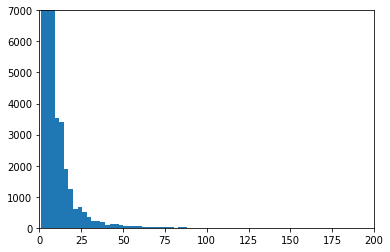

In [28]:
x = list(degree_out.keys())
y = list(degree_out.values())

plt.hist(y, bins = 500)
plt.ylim(0, 7000)
plt.xlim(0, 200)
plt.show()

We can see from the graph that the distribution is extremely skewed, with most of the out degrees belonging to only a small fraction of the nodes. This indicates the presence of hubs, i.e. a set of nodes that act as hubs in the sense that they point to authoritative nodes (those that have high in-degree, because many nodes point at them). 

**Degree in**

In [29]:
# nx implementation
node_degree_in = wiki_reduced.in_degree()

For the in-degree, instead, we take all the nodes from the graph, and for each of them we create a list of ones for all those times we encounter the node in the dictionary of out-bound links. That is, every time we encounter a node that points to it, we increase our 'counter' by one. 

In [ ]:
degree_in = defaultdict(int)

for i in wiki_reduced.nodes:
    degree_in[i] = sum([1  for elem in graph_dict.values() if i in elem])
    
with open('degree_in.pkl', 'wb') as f:
    pickle.dump(degree_in, f)

In [30]:
with open('degree_in.pkl', 'rb') as f:
    degree_in = pickle.load(f)

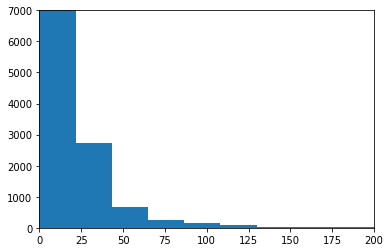

In [31]:
x = list(degree_in.keys())
y = list(degree_in.values())

plt.hist(y, bins = 500)
plt.ylim(0, 7000)
plt.xlim(0, 200)
plt.show()

Also here we find an extremely skewed distribution, but a bit less heterogeneous than before. In fact, also here we see that an extremely small fraction of the nodes accounts for almost all the inward edges of the graph. These nodes are called authorities. 

**Total degree**

In [32]:
# nx implementation

node_degree_tot = nx.degree(wiki_reduced)
type(wiki_reduced.nodes)

networkx.classes.reportviews.NodeView

In this case we have simply added the in-degrees and the out-degrees, but given that not all nodes are present in the dictionaries, we had to write nested exceptions to account for all possible cases. 

In [33]:
degree_tot = defaultdict(int)

for i in wiki_reduced.nodes:
    try:
        degree_tot[i] = degree_out[i] + degree_in[i] 
    except:
        try:
            degree_tot[i] = degree_out[i]
        except:
            try:
                degree_tot[i] = degree_in[i]
            except:
                degree_tot[i] = 0

with open('degree_tot.pkl', 'wb') as f:
    pickle.dump(degree_tot, f)

In [34]:
with open('degree_tot.pkl', 'rb') as f:
    degree_tot = pickle.load(f)

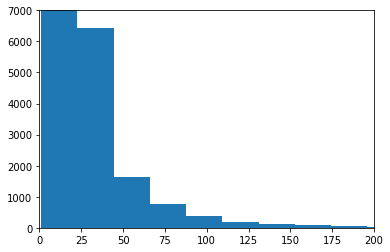

In [35]:
x = list(degree_tot.keys())
y = list(degree_tot.values())


plt.hist(y, bins = 500)
plt.ylim(0, 7000)
plt.xlim(0, 200)
plt.show()

The results are in line with what we had found for the out/in-degrees, that is about 25% of the nodes is connected to almost all the edges existing in the graph, which indicates the presence of hubs and authorities.

In [36]:
rand_choice = np.random.choice(wiki_reduced.nodes, 3)

for i in rand_choice:
    print('\nRandom node chosen:', i)
    print('Total degree as computed by us and by networkx, respectively:', degree_tot[i], node_degree_tot[i])
    print('Out degree as computed by us and by networkx, respectively:', degree_out[i], node_degree_out[i])
    print('In degree as computed by us and by networkx, respectively:', degree_in[i], node_degree_in[i])


Random node chosen: 1074420
Total degree as computed by us and by networkx, respectively: 1 1
Out degree as computed by us and by networkx, respectively: 1 1
In degree as computed by us and by networkx, respectively: 0 0

Random node chosen: 1169804
Total degree as computed by us and by networkx, respectively: 7 7
Out degree as computed by us and by networkx, respectively: 7 7
In degree as computed by us and by networkx, respectively: 0 0

Random node chosen: 825679
Total degree as computed by us and by networkx, respectively: 9 9
Out degree as computed by us and by networkx, respectively: 6 6
In degree as computed by us and by networkx, respectively: 3 3


The results match, meaning that the computations are correct!

# Q2
Define a function that takes in input:

* A page v
* A number of clicks d

and returns the set of all pages that a user can reach within d clicks.

To answer this question we have used the Breadth-First Search (BFS) Algorithm, because it finds all the vertices connected to the starting one with each 'click', which is exactly what the question asks. We have implemented it recursively. Also, to avoid wasting memory and computational power, at each iteration we save the length of the list of the new nodes we are adding to the visited ones, so that at the new iteration we will only visit the neighbours of the newly added nodes. 

In [37]:
def BFS_click(graph, d, v):
    '''
    recursive function  used to find the pages reachable in a given number of clicks
    input:graph, number of clicks d, page v
    output: touple of all pages that a user can reach within d clicks
    '''
    if d == 1:
        # if d = 1 we only visit the stating node neighbours
        new_visited_nodes = graph[v]
        return visited_nodes, np.array(new_visited_nodes).shape[0]
    if d == 2:
        # if d = 2 we consider only the stating node neighbours, and the neighbours' neighbours
        new_visited_nodes = [elem for i in graph[v] for elem in graph[i] if elem not in graph[v]]
        return graph[v] + new_visited_nodes, np.array(new_visited_nodes).shape[0]
    if d >= 3:
        # here we add the neighbours of the nodes that we added in the previous iteration, if we did not visit them before
        new_visited_nodes = [elem for i in BFS_click(graph, d-1, v)[0][-BFS_click(graph, d-1, v)[1]:] for elem in graph[i] if elem not in BFS_click(graph, d-1, v)[0]]
        
        return BFS_click(graph, d-1, v)[0] + new_visited_nodes, np.array(new_visited_nodes).shape[0]

In [38]:
def find_set_of_pages(graph):
    '''
    function that use DFS_click to find the set of the reachable pages
    input: graph, number of clicks d, page v
    output:  set with all the pages
    '''
    print('Choose a page number:')
    v = int(input())
    
    print('Choose a number of clicks')
    d = int(input())
    
    set_pages = BFS_click(graph_dict, d, v)[0]
    set_pages = list(set(set_pages))
    set_pages.sort()
    
    return set_pages

In [39]:
set_pages = find_set_of_pages(graph_dict)

Choose a page number:
Choose a number of clicks


In the following lines of codes we simply attach the names of the pages to the results of the function find_set_of_pages(), and present the final results in a dataframe. 

In [40]:
set_pages_names = []
for p in set_pages:
    name = pages_name_dict[p]
    set_pages_names.append(name)

In [41]:
result = pd.DataFrame([set_pages, set_pages_names]).T
result.columns = ['pages', 'pages_names']
print(result.shape)
result.head()

(131, 2)


,pages,pages_names
0,110209,Tina Fey
1,139762,Savion Glover
2,150451,22nd Century Lifestyle
3,358617,Jennifer Syme
4,397380,Issues 101


Set of all pages that a user can reach within d clicks:

Check if our function works as the in-built one

In [42]:
elements = list(nx.bfs_edges(wiki_reduced, source=95, depth_limit=3))
nx_dfs = list(list(zip(*elements))[1])
nx_dfs.sort()

In [43]:
set_pages == nx_dfs

True

## RQ3
<br>
<br>


Define a function that takes in input:

* A category $C$
* A set of pages in $C$, $p = {p1, ..., pn}$

and returns the minimum number of clicks required to reach all pages in $p$, starting from the page $v$, corresponding to the most central article, according to the in-degree centrality, in $C$.

Consider that:

* The algorithm needs to handle the case that the graph is not connected, thus not all the pages in $p$ are reachable from $v$. In such scenario, it is enough to let the program give in output the string "Not possible".
* Since we are dealing with graph exploration, you can pass more than once on the same page $p_i$.
* Since the problem’s complexity is high, consider to provide just an approximation/heuristic solution for the problem.
* You can use whatever metrics of centrality.

In [57]:
def in_degree_centrality(node, in_degree):
    max_deg = max(list(in_degree.values()))
    in_degree_node = in_degree[node]
    return round(in_degree_node/max_deg, 4)

In [58]:
def min_clicks(graph, c_0, categories):
    nodes = categories['pages'][c_0]
    list_centrality = [in_degree_centrality(node, degree_in) for node in nodes]
    v = nodes[np.argmax(np.array(list_centrality))]
    nodes.remove(v)
    clicks = [BFS_shortest_path(graph, v, i) for i in nodes]
    return clicks

In [2]:
min_clicks(graph_dict, 7883, new_pages_per_category)

## RQ4
<br>
<br>


Given in input two categories: $C_1$ and $C_2$, we get the subgraph induced by all the articles in the two categories.

**Comments:**

To create the subgraph we use the custom function `create_subgraph` to create the subgraph using two categories as input.

In [27]:
from functions import create_subgraph

sub_G = create_subgraph(wiki_reduced, new_pages_per_category, c1 = 970, c2 = 2682, random_pick=False)
print(nx.info(sub_G))

First index:  970
Second index:  2682
Name: 
Type: DiGraph
Number of nodes: 46
Number of edges: 20
Average in degree:   0.4348
Average out degree:   0.4348


**Question:**

* Let $v$ and $u$ two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect $u$ and $v$ ?


**Comments:**

To find the minimum set of hyperlinks to disconnect $u$ and $v$, we have created a custom function `min_remove_hyperlinks` that receives `source_node` and `target_node` from the user. 

The function handles the exceptions and return the list of edges to be cut and the number of minimum cuts to disconnect $u$ and $v$.

For more info check the docstrings in `functions.py` file.

In [29]:
from functions import min_remove_hyperlinks

print(min_remove_hyperlinks(sub_G, source_node= 537719 , target_node = 536093))

You need 1 cuts to disconnect them!

The List of hyperlinks to cut:
[(537719, 537591)]


In [30]:
print(min_remove_hyperlinks(sub_G, source_node= 537791 , target_node = 536093))

The source node is not in the graph


In [31]:
print(min_remove_hyperlinks(sub_G, source_node= 537719 , target_node = 536000))

The target node is not in the graph


In [32]:
print(min_remove_hyperlinks(sub_G, source_node= 544023 , target_node = 537665))

Source and Target are disconnected


# Q5

Given the fact that the graph is unweighted the shortest path can be more easily found by means of a BSF. In the following function we start from the given node and we check whether the destination node is one of its neighbours. Else, we keep on gatering the neighbours' neighbours and see if the destination node is contained in the newest visited nodes only. In the mean time, we add at each iteration the set of all the visited nodes into a list. If we visit all the nodes and we still haven't found the destination, then we exit the while loop and set the value of the 'shortest path' as infinite. 

In [48]:
def BFS_shortest_path(graph, start_node, destination):
    count = 1
    visited_nodes = graph[start_node]
    if destination in visited_nodes:
        count = 1
    else:
        new_visited_nodes = [elem for i in visited_nodes for elem in graph[i] if elem not in visited_nodes]
        count += 1
        visited_nodes = visited_nodes + new_visited_nodes
        while destination not in new_visited_nodes:
            if len(visited_nodes) < len_all_vertices:
                new_visited_nodes = [elem for node in new_visited_nodes for elem in graph[node] if elem not in visited_nodes]
                count += 1
                visited_nodes = visited_nodes + new_visited_nodes
            else: 
                count = np.inf
                print('There is no path between the nodes indicated')
                break
    return count

In [43]:
BFS_shortest_path(graph_dict, 95, 108)

There is no path between the nodes indicated


inf

In [54]:
# c_0 and c_1 are indexes of the new_pages_per_category dataframe
def category_shortest_path(graph, c_0, categories):
    source_nodes = categories['pages'][c_0]
    categories_distances = defaultdict(list)

    for i in categories.index:
        if i != c_0:
            destination_nodes = categories['pages'][i]
            paths = [BFS_shortest_path(graph, source, dest) for source in source_nodes for dest in destination_nodes if BFS_shortest_path(graph, source, dest) != np.inf]
            categories_distances[i] = np.median(np.array(paths))
    
    keys = categories_distances.keys()
    values = categories_distances.values()
    results = pd.DataFrame([keys, values]).T
    results.columns = ['categories', 'distance']
    results.sort_values('distance', inplace = True)
    categories_sorted = results['categories']
        
    return categories_sorted

In [1]:
category_shortest_path(graph_dict, 7883, new_pages_per_category)

# Q6
Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

For a first version of the PageRank algorithm implementation we had created the 'opposite_dict', that is the dictionary of the graph switched from having as keys the nodes and as values the outbound edges, to having as values the inbound edges, or in other words the list of nodes that point to the node of interest. We have then abandoned this implementation in favour of a random walk simulation. 

In [ ]:
opposite_dict = defaultdict(list)

for i in wiki_reduced.nodes:
    opposite_dict[i] = [idx for idx, elem in graph_dict.items() if i in elem]

with open('opposite_dict.pkl', 'wb') as f:
    pickle.dump(opposite_dict, f)

In [44]:
with open('opposite_dict.pkl', 'rb') as f:
    opposite_dict = pickle.load(f)

The PageRank of a node indicates the probability of finding ourselves in that node at any given point in time. The way we compute this value is the following (N = # nodes, $\lambda$ = probability of teleporting, y = nodes pointing to x, out(y)= out-degree of y):

$PR(x) = \frac{1-\lambda}{N} + \lambda * \Sigma_{y->x}(\frac{PR(y)}{out(y)})$

To recreate this, instead of using directly the formula, we have simulated a random walk with 1 million steps, where we initialize a dictionary in which each node has an initial pagerank score of zero, and we pick one starting node with uniform probability. Then we start our random walk, and at each step we choose randomly a number from a U(0,1). If the value is below 1-lambd (in the default case 0.15), then we pick the new node randomly considering all nodes equally likely (teleportation). If instead the value is below the threshold, then we pick randomly one of the neighbours of the nodes in which we are. At each step we increase the pagerank value of the node randomly picked by $\frac{1}{iters}$. The reason for the fraction is to have maintain the probabilistic setting. 

In [45]:
def pagerank(graph, N, iters, lambd = 0.85):
    init = dict(zip(graph.nodes, np.zeros(N)))
    x_0 = np.random.choice(graph.nodes, 1)[0]
    for i in range(iters):
        prob = np.random.random()
        if prob < (1-lambd): #teleport
            next_node = np.random.choice(graph.nodes, 1)[0]
            init[next_node] = init[next_node] + 1/iters
            x_0 = next_node
        else: # out_links
            try:
                next_node = np.random.choice(graph_dict[x_0], 1)[0]
            except ValueError:
                next_node = np.random.choice(graph.nodes, 1)[0]
            init[next_node] = init[next_node] + 1/iters
            x_0 = next_node

    return init

In [87]:
pr_dict = pagerank(graph = wiki_reduced, N = len_all_vertices, iters = 1000000, lambd = 0.85)

Please notice that although the algorithm specifically refers to a random walk, in theory it should be a rando walk that goes infinitely, while we 'only' implement 1 million steps. This means that for sure the numbers will not coincide perfectly with those of the nx implementation, but as long as they are close enough, then it means that the implementation is correct. 

In [94]:
# Check with nx
pr_nx = nx.pagerank(wiki_reduced)

rand_choice = np.random.choice(wiki_reduced.nodes, 3)

for i in rand_choice:
    print('\nRandom node chosen:', i)
    print('PageRank as computed by us and by networkx, respectively:', pr_dict[i], pr_nx[i])


Random node chosen: 1362579
PageRank as computed by us and by networkx, respectively: 1e-06 2.528391685857188e-06

Random node chosen: 89314
PageRank as computed by us and by networkx, respectively: 3e-06 1.7792932243659e-06

Random node chosen: 82995
PageRank as computed by us and by networkx, respectively: 1.9000000000000004e-05 1.4935760915297014e-05


Finally, to create the pagerank of each category, we simply add the pagerank of each of the nodes belonging to the category.

In [ ]:
categories_pr = defaultdict(int)
categories_prnx = defaultdict(int)

for node in wiki_reduced.nodes:
    category = category_for_node[node]
    categories_pr[category] += pr_dict[node]
    categories_prnx[category] += pr_nx[node]

In [104]:
keys = categories_pr.keys()
values_1 = categories_pr.values()
values_2 = categories_prnx.values()
final_pagerank = pd.DataFrame([keys, values_1, values_2]).T
final_pagerank.columns = ['category', 'our_pagerank', 'nx_pagerank']
final_pagerank['category'] = final_pagerank['category'].astype(int)
final_pagerank.sort_values('our_pagerank', inplace = True, ascending = False)
final_pagerank.head()

,category,our_pagerank,nx_pagerank
146,8732,0.080041,0.079858
11,11649,0.040787,0.040084
1,1047,0.037993,0.038382
774,7889,0.029824,0.028523
2,10555,0.029238,0.029257


As we can see from the results per category, our implementation only slightly differs from that of nx. Probably with more than one million steps in the random walk we could have reached even a better precision. 